In [55]:
import kohonen
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
import matplotlib.pylab as plb

In [3]:
def center_position(points):
    c = np.mean(points, axis=0)
    assert len(c) == len(points[0])
    return c

In [4]:
def distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

In [5]:
def center_for_point_index(p, centers):
    """
    returns the index of the center that is closest to p
    """
    return np.argmin(centers - p)
def center_for_point(p, centers):
    """
    returns the center closest to p
    """
    return centers[center_for_point_index(p, centers)]

In [ ]:
def stab_score_dict(stability_dict):
    score = 0
    for stab in stability_dict.values():
        diff = min(1-stab, stab)
        score += ((1+diff)**2)-1
    return score/len(stability_dict)

In [ ]:
def update_stab_dict(stability_dict, centers, t, r):
    for p, stab in stability_dict.items():
        n = neigh_r(p[0].unwrap(), p[1].unwrap(), centers, r)
        stability_dict[p] = (t*stab + n) / (t+1)

In [ ]:
def init_assign_stab(data, size):
    assign_matrix = [[0 for x in range(np.shape(data)[0])] for y in range(np.shape(data)[1])] 
    return assign_matrix
    

In [ ]:
def update_assign_stab():
    

In [39]:
def label_digits(data, labels, centers, targetdigits, size_k):
    # select all the labels correponding to targetdigits
    labels = labels[np.logical_or.reduce([labels==x for x in targetdigits])]
    # Initialize indexes and digits
    closest = 0;
    digits = []
    # iterate over size of kohonen map
    for i in range(0, size_k**2):
            #find the closest point to ith center
            closest = np.argmin(np.sum((data[:] - centers[i, :])**2, axis=1))
            digits.append(labels[closest])

    return np.reshape(digits, (size_k, size_k))

## Function definitions

In [63]:
def kohonen():
    """Example for using create_data, plot_data and som_step.
    """
    plb.close('all')
    
    dim = 28*28
    data_range = 255.0
    
    # load in data and labels    
    data = np.array(np.loadtxt('data.txt'))
    labels = np.loadtxt('labels.txt')

    # select 4 digits    
    name = 'Josselin Vallée' # REPLACE BY YOUR OWN NAME
    targetdigits = name2digits(name) # assign the four digits that should be used
    print targetdigits # output the digits that were selected
    # this selects all data vectors that corresponds to one of the four digits
    data = data[np.logical_or.reduce([labels==x for x in targetdigits]),:]
    
    dy, dx = data.shape
    
    #set the size of the Kohonen map. In this case it will be 6 X 6
    size_k = 6
    
    #set the width of the neighborhood via the width of the gaussian that
    #describes it
    sigma = 2.0
    
    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range
    
    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))

    #set the learning rate
    eta = 0.7 # HERE YOU HAVE TO SET YOUR OWN LEARNING RATE
    
    #set the maximal iteration count
    tmax = 20000 # this might or might not work; use your own convergence criterion
    
    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % dy
    np.random.shuffle(i_random)
    
    previous_centers = np.copy(centers)
    mean_mov = []
    for t, i in enumerate(i_random):
        som_step(centers, data[i,:],neighbor,eta,sigma)
        mean_mov.append(np.sum(np.sum((previous_centers - centers)**2,1)))
        previous_centers=np.copy(centers)
    
    print(label_digits(data, labels, centers, targetdigits, size_k))

    # for visualization, you can use this:
    for i in range(size_k**2):
        plb.subplot(size_k,size_k,i+1)
        
        plb.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')
        plb.axis('off')
    # leave the window open at the end of the loop
    plb.show()
    plb.draw()
    plb.plot(mean_mov)
    plt.show()

In [65]:
def som_step(centers,data,neighbor,eta,sigma):
    """Performs one step of the sequential learning for a 
    self-organized map (SOM).
    
      centers = som_step(centers,data,neighbor,eta,sigma)
    
      Input and output arguments: 
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (vector) the actually presented datapoint to be presented in
                         this timestep
       neighbor (matrix) the coordinates of the centers in the desired
                         neighborhood.
       eta      (scalar) a learning rate
       sigma    (scalar) the width of the gaussian neighborhood function.
                         Effectively describing the width of the neighborhood
    """
    
    size_k = int(np.sqrt(len(centers)))
    
    #find the best matching unit via the minimal distance to the datapoint
    b = np.argmin(np.sum((centers - np.resize(data, (size_k**2, data.size)))**2,1))

    # find coordinates of the winner
    a,b = np.nonzero(neighbor == b)
        
    # update all units
    for j in range(size_k**2):
        # find coordinates of this unit
        a1,b1 = np.nonzero(neighbor==j)
        # calculate the distance and discounting factor
        disc=gauss(np.sqrt((a-a1)**2+(b-b1)**2),[0, sigma])
        # update weights        
        centers[j,:] += disc * eta * (data - centers[j,:])

In [19]:
def gauss(x,p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))

In [37]:
def name2digits(name):
    """ takes a string NAME and converts it into a pseudo-random selection of 4
     digits from 0-9.
     
     Example:
     name2digits('Felipe Gerhard')
     returns: [0 4 5 7]
     """
    
    name = name.lower()
    
    if len(name)>25:
        name = name[0:25]
        
    primenumbers = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]
    
    n = len(name)
    
    s = 0.0
    
    for i in range(n):
        s += primenumbers[i]*ord(name[i])*2.0**(i+1)

    import scipy.io.matlab
    Data = scipy.io.matlab.loadmat('hash.mat',struct_as_record=True)
    x = Data['x']
    t = np.mod(s,x.shape[0])

    return np.sort(x[t,:])

/home/josselin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[0 1 2 5]
[[ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  5.]
 [ 1.  1.  1.  1.  5.  5.]
 [ 1.  1.  1.  5.  5.  5.]
 [ 1.  5.  5.  5.  5.  5.]]


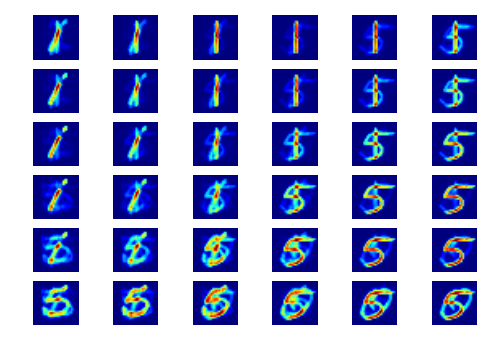

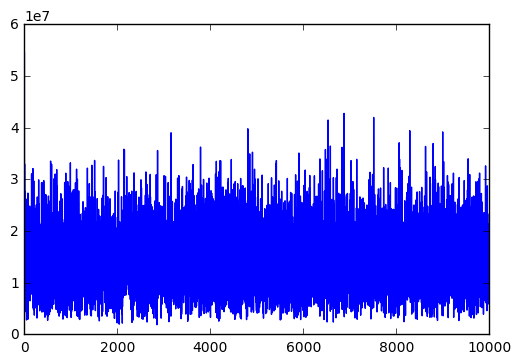

In [66]:
kohonen()